## Import

In [2]:
import os
import sys
import pickle
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math


In [3]:
print(torch.__version__)
print(pd.__version__)

2.6.0+cu118
2.2.3


## Config

In [4]:
config = {
    "seed": 0,
    "cutoff_date": "2020-01-01",
    "test_cutoff_date": "2022-05-01",
    "max_len": 384,
    "batch_size": 1,
    "learning_rate": 1e-4,
    "weight_decay": 0.0,
    "mixed_precision": "bf16",
    "model_config_path": "../working/configs/pairwise.yaml",  # Adjust path as needed
    "epochs": 1,
    "loss_power_scale": 1.0,
    "max_cycles": 1,
    "grad_clip": 0.1,
    "gradient_accumulation_steps": 1,
    "d_clamp": 30,
    "max_len_filter": 9999999,
    "min_len_filter": 10,
    "structural_violation_epoch": 50,
    "balance_weight": False,
    "n_tokens": 4,
    "d_model": 256,
    "n_heads": 8,
    'dropout': 0.1,
}

## Set Sample Data To make Model

In [62]:
os.getcwd()

'c:\\Users\\solba\\Desktop\\25_1_Capstone1\\WuSubSol'

In [63]:
folder_path = '../pdb_pipeline'

train_labels = pd.read_csv(os.path.join(folder_path, 'pdb_labels_5models.csv'))

train_sequences = pd.read_csv(os.path.join(folder_path, 'pdb_sequences_5models.csv'))

print(train_labels.head())

print(train_sequences.head())


          ID resname  resid    x_1    y_1     z_1    x_2    y_2     z_2  \
0   124D_B_9       C      9 -0.471 -6.788  18.299 -0.471 -6.788  18.299   
1  124D_B_10       A     10 -5.581 -5.427  16.282 -5.581 -5.427  16.282   
2  124D_B_11       U     11 -7.964 -1.483  13.892 -7.964 -1.483  13.892   
3  124D_B_12       G     12 -8.050  3.242  11.526 -8.050  3.242  11.526   
4  124D_B_13       U     13 -5.350  7.000   8.973 -5.350  7.000   8.973   

     x_3    y_3     z_3    x_4    y_4     z_4    x_5    y_5     z_5  
0 -0.471 -6.788  18.299 -0.471 -6.788  18.299 -0.471 -6.788  18.299  
1 -5.581 -5.427  16.282 -5.581 -5.427  16.282 -5.581 -5.427  16.282  
2 -7.964 -1.483  13.892 -7.964 -1.483  13.892 -7.964 -1.483  13.892  
3 -8.050  3.242  11.526 -8.050  3.242  11.526 -8.050  3.242  11.526  
4 -5.350  7.000   8.973 -5.350  7.000   8.973 -5.350  7.000   8.973  
  target_id               sequence temporal_cutoff  description  all_sequences
0    124D_B               CAUGUGAC      1993-05-07

In [64]:
train_labels["pdb_id"] = train_labels["ID"].apply(lambda x: x.split("_")[0]+'_'+x.split("_")[1])
train_labels["pdb_id"]

0         124D_B
1         124D_B
2         124D_B
3         124D_B
4         124D_B
           ...  
250737    9MX5_C
250738    9MX5_C
250739    9MX5_C
250740    9MX5_C
250741    9MX5_C
Name: pdb_id, Length: 250742, dtype: object

In [65]:
all_xyz=[]

for pdb_id in tqdm(train_sequences['target_id']):
    df = train_labels[train_labels["pdb_id"]==pdb_id]
    #break
    xyz=df[['x_1','y_1','z_1','x_2','y_2','z_2','x_3','y_3','z_3','x_4','y_4','z_4','x_5','y_5','z_5',]].to_numpy().astype('float32')
    xyz[xyz<-1e17]=float('Nan');
    all_xyz.append(xyz)

# all_xyz[13]

100%|██████████| 3806/3806 [01:04<00:00, 58.99it/s]


### filter data

In [66]:
# filter the data
# Filter and process data
filter_nan = []
max_len = 0
filter_ratio = 0 # All data are valid
for xyz in all_xyz:
    if len(xyz) > max_len:
        max_len = len(xyz)

    filter_nan.append((np.isnan(xyz).mean() <= filter_ratio) & \
                      (len(xyz)<config['max_len_filter']) & \
                      (len(xyz)>config['min_len_filter']))


print(f"Longest sequence in train: {max_len}")

filter_nan = np.array(filter_nan)
non_nan_indices = np.arange(len(filter_nan))[filter_nan]
print('remain sequences:', len(non_nan_indices))
train_sequences = train_sequences.loc[non_nan_indices].reset_index(drop=True)
non_nan_xyz=[all_xyz[i] for i in non_nan_indices]

Longest sequence in train: 2900
remain sequences: 2533


In [67]:
#pack data into a dictionary

data={
      "pdb_id":train_sequences['target_id'].to_list(),
      "sequence":train_sequences['sequence'].to_list(),
      "temporal_cutoff": train_sequences['temporal_cutoff'].to_list(),
      "description": train_sequences['description'].to_list(),
      "all_sequences": train_sequences['all_sequences'].to_list(),
      "xyz": non_nan_xyz
}
print(data['pdb_id'][1])
print(data['sequence'][1])
print(data['temporal_cutoff'][1])
print(data['description'][1])
print(data['all_sequences'][1])
# print(data['xyz'][1])

1A1T_B
GGACUAGCGGAGGCUAGUCC
1997-12-15
nan
nan


### Split Train / Validation set

In [68]:
# Split data into train and test
all_index = np.arange(len(data['sequence']))
cutoff_date = pd.Timestamp(config['cutoff_date'])
test_cutoff_date = pd.Timestamp(config['test_cutoff_date'])
train_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) <= cutoff_date]
test_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) > cutoff_date and pd.Timestamp(d) <= test_cutoff_date]

### To Pytorch Dataset

In [69]:
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval

def get_ct(bp,s):
    ct_matrix=np.zeros((len(s),len(s)))
    for b in bp:
        ct_matrix[b[0]-1,b[1]-1]=1
    return ct_matrix

class RNA3D_Dataset(Dataset):
    def __init__(self,indices,data):
        self.indices=indices
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}
        # self.tokens = {'A': 2, 'U':-2, 'G':3, 'C':-3}

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):

        idx=self.indices[idx]
        sequence=[self.tokens[nt] for nt in (self.data['sequence'][idx])]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        #get C1' xyz
        xyz=self.data['xyz'][idx]
        xyz=torch.tensor(np.array(xyz))


        if len(sequence)>config['max_len']:
            crop_start=np.random.randint(len(sequence)-config['max_len'])
            crop_end=crop_start+config['max_len']

            sequence=sequence[crop_start:crop_end]
            xyz=xyz[crop_start:crop_end]
        #center at first atom if first atom does not exit go until it does
        for i in range(len(xyz)):
            if (~torch.isnan(xyz[i])).all():
                break
        xyz=xyz-xyz[i]

        return {'pbd_id':self.data['pdb_id'][idx],
            'sequence':sequence,
                'xyz':xyz}

In [70]:
train_dataset=RNA3D_Dataset(train_index,data)
val_dataset=RNA3D_Dataset(test_index,data)

In [71]:
print(train_dataset[0]['xyz'][2])


tensor([-11.5840,  -1.9270,  -0.0570, -10.9290,   2.5640,   2.3630, -11.3600,
         -4.0740,  -0.0880, -10.9900,   2.7140,   1.7140, -10.7080,   4.4850,
         -0.1930])


In [72]:
train_loader=DataLoader(train_dataset,batch_size=1,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=1,shuffle=False)

print(train_dataset[0]['xyz'][2])


tensor([-11.5840,  -1.9270,  -0.0570, -10.9290,   2.5640,   2.3630, -11.3600,
         -4.0740,  -0.0880, -10.9900,   2.7140,   1.7140, -10.7080,   4.4850,
         -0.1930])


## Model definition

### Example with one data

In [205]:
num_seq = 1

src = train_dataset[num_seq]['sequence']
tgt = train_dataset[num_seq]['xyz']

print(src, len(src))
print(train_dataset[num_seq]['pbd_id'])
# print(tgt)

tensor([2, 2, 0, 1, 3, 0, 2, 1, 2, 2, 0, 2, 2, 1, 3, 0, 2, 3, 1, 1]) 20
1A1T_B


### Check Pairwise

21
GGCGUAAGGAUUACCUAUGCC
<class 'torch.Tensor'>
torch.Size([21, 21])


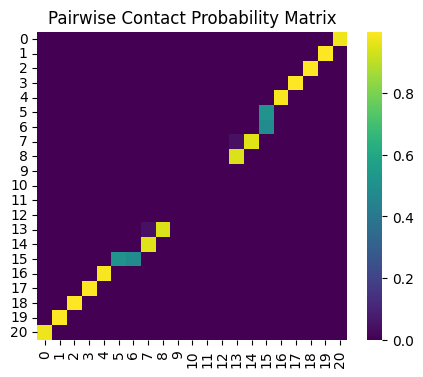

In [6]:
import RNA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

src = torch.tensor([2, 2, 1, 2, 3, 0, 0, 2, 2, 0, 3, 3, 0, 1, 1, 3, 0, 3, 2, 1, 1], dtype=torch.long)
# AUGC를 0123으로 매핑
nucleotide_map = {0: 'A', 1: 'C', 2: 'G', 3: 'U'}

str_A = ''.join([nucleotide_map[x.item()] for x in src])

print(len(str_A))
print(str_A)

md = RNA.md()

fc = RNA.fold_compound(str_A, md)

# predict Minmum Free Energy and corresponding secondary structure
# (ss, mfe) = 
# print(fc.mfe())
fc.pf()
B = torch.tensor(fc.bpp())

# B = torch.tensor(B)
B = B[1:,1:]
print(type(B))
print(B.shape)
B = B + B.T
# B = np.array(B, dtype=np.bool())
# print(B)

plt.figure(figsize=(5,4))
sns.heatmap(B, cmap='viridis', annot=False)  # annot=True로 설정하면 각 셀에 값 표시
plt.title('Pairwise Contact Probability Matrix')
plt.show()


In [31]:
from torch import einsum
from einops import rearrange, repeat, reduce

class Outer_Product_Mean(nn.Module):
    def __init__(self, in_dim=256, dim_msa=32, pairwise_dim=64):
        super(Outer_Product_Mean, self).__init__()
        self.proj_down1 = nn.Linear(in_dim, dim_msa)
        self.proj_down2 = nn.Linear(dim_msa ** 2, pairwise_dim)

    def forward(self,seq_rep, pair_rep=None):
        seq_rep=self.proj_down1(seq_rep)
        outer_product = torch.einsum('bid,bjc -> bijcd', seq_rep, seq_rep)
        outer_product = rearrange(outer_product, 'b i j c d -> b i j (c d)')
        print("1",outer_product.shape)
        outer_product = self.proj_down2(outer_product)

        if pair_rep is not None:
            outer_product=outer_product+pair_rep

        return outer_product

In [ ]:
import RNA
import torch.nn.functional as F

class Outer_Product_Mean(nn.Module):
    def __init__(self, in_dim=256, dim_msa=32, pairwise_dim=64):
        super(Outer_Product_Mean, self).__init__()
        self.proj_down1 = nn.Linear(in_dim, dim_msa)
        self.proj_down2 = nn.Linear(dim_msa ** 2, pairwise_dim)

    def forward(self,seq_rep, pair_rep=None):
        seq_rep=self.proj_down1(seq_rep)
        outer_product = torch.einsum('bid,bjc -> bijcd', seq_rep, seq_rep)
        outer_product = rearrange(outer_product, 'b i j c d -> b i j (c d)')
        outer_product = self.proj_down2(outer_product)

        if pair_rep is not None:
            outer_product=outer_product+pair_rep

        return outer_product

def get_pairwise_features(src, seq_len, d_model):
    nucleotide_map = {0: 'A', 1: 'C', 2: 'G', 3: 'U'}

    # print("pairwise",src)
    src = src.squeeze(0)
    str_seq = ''.join([nucleotide_map[x.item()] for x in src])
    # print("str_seq",str_seq)
    
    md = RNA.md()
    fc = RNA.fold_compound(str_seq, md)
    fc.pf() ##???

    pair_matrix = torch.tensor(fc.bpp(), dtype=torch.float32)
    # print("pair_matrix",pair_matrix)
    pair_matrix = pair_matrix[1:,1:] # remove first row and column 0 index in bpp is always 0
    pair_matrix = pair_matrix + pair_matrix.T # symmetric matrix

    pair_matrix = pair_matrix.unsqueeze(0).unsqueeze(0)
    pair_matrix = F.interpolate(pair_matrix, size=(d_model, d_model), mode='bilinear', align_corners=False)
    # pair_matrix = F.interpolate(pair_matrix, size=(d_model, d_model), mode='nearest', align_corners=False)

    pair_matrix = pair_matrix.squeeze()
    # print("pair_matrix",pair_matrix.shape)

    return pair_matrix

class pos_encoding(nn.Module):
    def __init__(self, seq_len, d_model):
        super().__init__()
        # self.pos_encoding = torch.zeros(seq_len, d_model)

        for pos in range(seq_len):
            for i in range(d_model):
                if i % 2 == 0:
                    self.pos_encoding[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
            else:
                pos_encoding[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

    def forward(self, sequence):
        return self.pos_encoding
    
# class relpos(nn.Module):
#     def __init__(self, d_model):
#         super().__init__()
#         self.linear = nn.Linear(33, dim)

#     def forward(self, src):

class embed_sequence(nn.Module):
    def __init__(self, d_model, n_tokens = config['n_tokens']):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model)
        self.pos_encoding = pos_encoding(d_model)
        
    def forward(self, sequence):
        seq_len = len(sequence.squeeze())
        sequence = sequence.long()
        return self.embedding(sequence)
    

class multihead_att(nn.Module):
    def __init__(self, d_model, n_heads=8):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        
        self.w_q = nn.Linear(d_model, n_heads * self.d_head)
        self.w_k = nn.Linear(d_model, n_heads * self.d_head)
        self.w_v = nn.Linear(d_model, n_heads * self.d_head)

        # self.w_o = nn.Linear(n_heads * self.d_head, d_model)
        
    def forward(self, query, key, value):
        batch_size, length, d_model = query.size()
        
        q = self.w_q(query)
        k = self.w_k(key)
        v = self.w_v(value)

        q = q.view(batch_size, length, self.n_heads, self.d_head)
        k = k.view(batch_size, length, self.n_heads, self.d_head)
        v = v.view(batch_size, length, self.n_heads, self.d_head)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)  
        output = torch.matmul(scores, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, length, -1)
        
        return output


class feedforward(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.w_1 = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.w_2 = nn.Linear(d_model, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.w_1(x)
        x = self.norm(x)
        x = self.w_2(x)
        x = self.activation(x)

        return x


def residual_connection_one(x, sublayer):
    return x + sublayer(x)

def residual_connection_attention(x, sublayer):
    return x + sublayer(x,x,x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        
        # self.encoder = pos_encoding(4, d_model)
        self.activation = nn.ReLU()
        
        self.attention = multihead_att(d_model, n_heads)
        self.feedforward = feedforward(d_model)

    def forward(self, src, pairwise_feature):
        src_temp = src
        # src = residual_connection(src, self.encoder(src))
        src = residual_connection_attention(src, self.attention)
        
        src = residual_connection_one(src, self.feedforward)
        
        return src




class WuSubSol(nn.Module):
    def __init__(self, config):
        super(WuSubSol, self).__init__()
        self.config = config
        self.d_model = config['d_model']

        self.embedding = embed_sequence(self.d_model)


        self.encoder_layers = []
        # for i in range(config['n_layers']):
        for i in range(2):
            self.encoder_layers.append(EncoderLayer(self.d_model, config['n_heads'], config['dropout']))

        self.encoder_layers = nn.ModuleList(self.encoder_layers)

        # self.decoder = nn.Linear(config['d_model'], config['vocab_size'])

    def forward(self, src):

        seq_len = len(src)
        pairwise_feature = get_pairwise_features(src, seq_len, self.d_model)

        src = self.embedding(src)

        src = src.unsqueeze(0)

        for i,layer in enumerate(self.encoder_layers):
            # print("before",src.shape)
            src = layer(src, pairwise_feature)
            # print("after",src.shape)


        return src



In [9]:
model = WuSubSol(config)
print(model)


NameError: name 'seq_len' is not defined

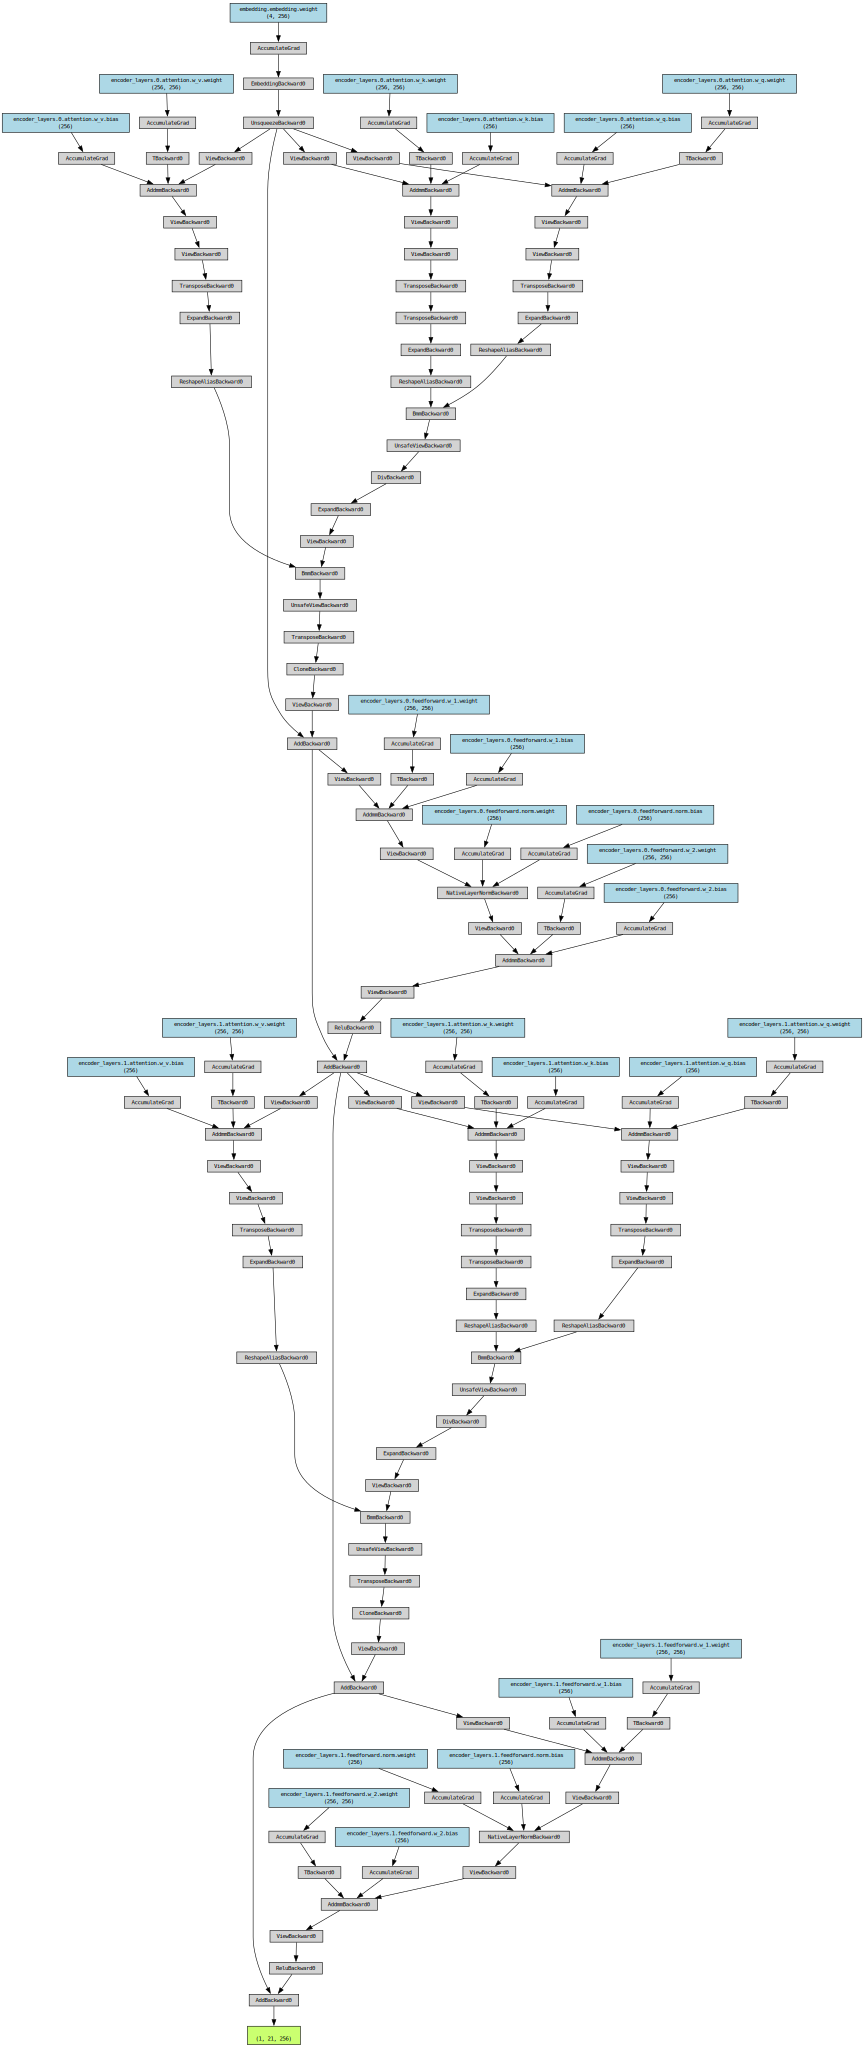

In [18]:
from torchviz import make_dot
A = torch.tensor([2, 2, 1, 2, 3, 0, 0, 2, 2, 0, 3, 3, 0, 1, 1, 3, 0, 3, 2, 1, 1], dtype=torch.float32, requires_grad=True)
model = WuSubSol(config)
# 모델에 맞는 더미 입력 데이터 생성

y = model(A)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', A)]))
# make_dot(y.mean(), params=dict(list(model.named_parameters()) + [('x', A)]))
